## Installing needed libraries


In [1]:
! pip install d2l # for the sentiment analysis model

In [2]:
!pip install demoji # for replacing the emojis in tweets with their description

In [3]:
# !pip install pyspellchecker # we are skipping spellchecking in sake of saving time

In [4]:
# may be needed in order to avoid some errors that could raise from d2l library due to incompatibality of versions
# ! pip uninstall matplotlib
# ! pip install -U matplotlib

In [5]:
! pip install snscrape     # a library to scrap tweets insted of 'twint' library we were using

In [6]:
! pip install nltk # for natural language processing 

## Mounting to google drive 
this step is mandatory in order to read and save data there


In [7]:
# Mounting to google drive
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


## Importing needed libraries

In [8]:
import pandas as pd
import numpy as np
import re
import string
import sys
import os

import nltk
from nltk.corpus import stopwords, words
import spacy
from spacy.lang.en import STOP_WORDS
import demoji

import torch
from torch import nn
from d2l import torch as d2l

import nltk
import snscrape.modules.twitter as sntwitter

import matplotlib.pyplot as plt
import numpy as np


## Scraping Data from Twitter
P.S: In this part you can either change the following variables 

```
date='2019-09-20'
search_string= '#iPhone13'
numOfTweets= 100
```
and go through the code step by step to scrap the twitter for you selected inforamtion, or you can skip this part and go straight to the part named (read collected data) in order to load the already scrapped data and continue from there.


In [9]:
default_date='2019-09-20'
default_search_string='#iPhone13'

In [131]:
date='2021-01-01'  #if you have decided to change the date, please follow the same formatting as the default value
search_string= '#iPhone13'
numOfTweets= 100
end_date='2022-04-01'
# you can choose the number of tweets to be scrapped, 
# but it is recommended to avoid choosing a large number in the sake of saving time of scrapping and cleaning the data

In [59]:
# Defining a function to scrap 'search_string' mentioned in tweets since a specific date 'since' within the limit 'limit' of tweets.
def tweet_search(since_date, search_string,limit):
    # Creating list to append tweet data to
    tweets_list2 = []
    # Using TwitterSearchScraper to scrape data and append tweets to list
    for i,tweet in enumerate(sntwitter.TwitterSearchScraper(search_string+'since:'+since_date+'until:'+end_date+'near:"London"').get_items()):
      if i>numOfTweets:
        break
      tweets_list2.append([tweet.date, tweet.id, tweet.content])
    # Creating a dataframe from the tweets list above
    tweets_df2 = pd.DataFrame(tweets_list2, columns=['Datetime', 'Tweet Id', 'Text'])
    return tweets_df2

In [60]:
# calling the scraping function
df=tweet_search(date,search_string,numOfTweets)

In [61]:
# checking the dataframe columns
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41 entries, 0 to 40
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype              
---  ------    --------------  -----              
 0   Datetime  41 non-null     datetime64[ns, UTC]
 1   Tweet Id  41 non-null     int64              
 2   Text      41 non-null     object             
dtypes: datetime64[ns, UTC](1), int64(1), object(1)
memory usage: 1.1+ KB


In [62]:
df.head()

,Datetime,Tweet Id,Text
0,2022-03-30 11:50:30+00:00,1509135980300701697,Nice little walk around London shooting with j...
1,2022-03-11 10:17:23+00:00,1502227177504448519,We’ve added some new designs to our iPhone cas...
2,2022-03-09 00:45:37+00:00,1501358509450883079,Your like a stomach with a big I’m a rare dise...
3,2022-03-07 12:42:03+00:00,1500814031359250432,The Harber London Magnetic Envelope Sleeve For...
4,2022-02-20 09:19:44+00:00,1495327296705773568,London #Pilotlife #aviation #iphone13 https://...


In [35]:
# printing a tweet as an example
df['Text'][1]

'We’ve added some new designs to our iPhone case collection. Whoever said an elephant can’t do \U0001fa70? https://t.co/gnyZCN1h7G #elephant #iPhone13 #iphonecase #tech #artist #ballet #theatre #London #giftsforher @Etsy https://t.co/JMw0FUBIhs'

In [63]:
collected_data=df # renaming

## Read collected data
In this part we read the default dataset note that we had already scraped and saved it, if you have just scrapped different data so you can skip this part.

In [93]:
default_date='2019-09-20'
default_search_string='#iPhone13'
search_string=default_search_string

In [56]:
collected_data = pd.read_csv("/content/drive/MyDrive/scrapped_data/"+default_search_string+"_"+default_date+".csv") 

## Cleaning Data 
In this step you can either go through the code step by step (run each cell) and clean the data you have scrapped/read, or you can skip the cleaning part and go straight to the part with the name (read cleaned data) which will read a file with default cleaned data ( a data we have already scrapped from twitter and cleaned it through the following cleaning pipeline)

In [59]:
nlp = spacy.load('en_core_web_sm')  # English pipeline optimized for CPU. Components: tok2vec, tagger, parser, senter, ner, attribute_ruler, lemmatizer.
#stop_words = set(stopwords.words('english')) #Uploading Stopwords
#words = set(nltk.corpus.words.words()) # set of english words
#spell = SpellChecker() 
table = str.maketrans('', '', string.punctuation) # table to delete the punctuation from the texts by using string library

In [57]:
tweets=collected_data["Text"].values.tolist() # tweets list contains the scraped tweets

In [54]:
def cleaning(text): 
    # Replacing emojis with their describtion
    # print(text)
    no_emoji=demoji.replace_with_desc(text," ") 
    no_at = re.sub("@[A-Za-z0-9]+","",no_emoji) #Remove @ sign
    no_link = re.sub(r"(?:\@|http?\://|https?\://|www)\S+", "", no_at) #Remove http links
    no_hashtag = no_link.replace("#", "").replace("_", " ") #Remove hashtag sign but keep the text
    no_asci=re.sub(r'[^\x00-\x7f]',r' ',no_hashtag) #non asci
    no_punc=no_asci.translate(table) #delete punctuals
    #tweet = " ".join(w for w in nltk.wordpunct_tokenize(no_punc) #  splitting the tweet into tokens
    #     if w.lower() in words and w.isalpha())
    return no_punc

Earlier we have included a spellchecker part in the data cleaning pipeline, after trails we have came to a conclusion that this way of spell checking consume time and it is better to eliminate it from the data cleaning pipeline.

In [ ]:
#def spell_checking(text):
    # Fixing Word Lengthening, which occurs when characters are wrongly repeated. 
    # English words have a max of two repeated characters. Additional characters need to ripped off, 
    #3pattern = re.compile(r"(.)\1{2,}")
    #length_fixed= pattern.sub(r"\1\1", text)
    #tweet = " ".join(w if (w[0].isupper()) else spell.correction(w) for w in nltk.wordpunct_tokenize(length_fixed) )
    #return(tweet)

In [132]:
 search_string_no_hashtag =search_string.replace("#", "").replace("_", " ").lower()
 loc='london'

In [127]:
def nlp_analyzing(text):    
    doc = nlp(text)
    lemmas = []
    for token in doc:
        if token.lang_ == 'en' and token.pos_ != 'SPACE' : #and token.text not in STOP_WORDS:
            if token.text.lower() in [search_string_no_hashtag,loc] :
                continue
            elif token.ent_type_!="":  # if the token is recognized as a Name Entity
                lemmas.append(token.text.lower())
            else: # token.text.lower() in words: #Checking if the word is in the dictionary (meaningful english world)
                lemmas.append(token.lemma_)
    return ' '.join(lemmas)

In [53]:
def clean(data): # Data Cleaning pipeline
    cleaned_data=[nlp_analyzing(cleaning(x)) for x in data]
    return cleaned_data
    #return data.apply(lambda x : nlp_analyzing(spell_checking(cleaning(x))))

In [65]:
tweets[0] # printing a tweet before cleaning it

'Nice little walk around London shooting with just the iPhone 13 pro #london #trains #iphone13 #iphone13pro #londonphotography @ London, United Kingdom https://t.co/ZhNvSlPUyA'

In [44]:
nlp_analyzing(cleaning(tweets[0])) # cleaning the same tweet and printing it

'nice little walk around London shoot with just the iPhone 13 pro london trains iphone13 iphone13pro londonphotography London United Kingdom'

In [129]:
cleaned=clean(tweets) # cleaning the tweets

## Read cleaned data
you can skip this part if you would like to complete with the data you have scrapped and cleaned, otherwise run the following cell please

In [10]:
default_date='2019-09-20'
default_search_string='#iPhone13'

In [77]:
file_name="/content/drive/MyDrive/cleaned_data/"+default_search_string+"_"+default_date+".txt"

In [78]:
data = pd.read_csv(file_name, sep="\n", header=None)

In [90]:
cleaned=data[0].values.tolist()

## Printing word cloud after cleaning the data

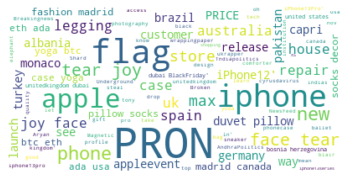

In [134]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud
# plotting a word cloud of positive mentions of iPhone13 in the tweets
wordcloud = WordCloud(max_font_size=50, max_words=100, background_color="white").generate(str(cleaned))
plt.figure()
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

## saving cleaned data
you can skip this part if you have not scrapped new data, or if youhave scrapped new data and you do not wish to save it

In [133]:
# writing the results to a file 
with open("/content/drive/MyDrive/cleaned_data/"+search_string+"_"+date+".txt", 'w') as f:
    for item in cleaned:
        f.write("%s\n" % item)

## Creating RNN model for sentiment analysis. 

### Reading data to be used as training and testing data


In [18]:
batch_size = 64
train_iter, test_iter, vocab = d2l.load_data_imdb(batch_size)

### Creating a class to build a RNN (LSTM) model to predict sentamic 

In [15]:
class BiRNN(nn.Module):
    def __init__(self, vocab_size, embed_size, num_hiddens,
                 num_layers, **kwargs):
        super(BiRNN, self).__init__(**kwargs)
        self.embedding = nn.Embedding(vocab_size, embed_size)
        # Set `bidirectional` to True to get a bidirectional RNN
        self.encoder = nn.LSTM(embed_size, num_hiddens, num_layers=num_layers,
                                bidirectional=True)
        self.decoder = nn.Linear(4 * num_hiddens, 2)

    def forward(self, inputs):
        # The shape of `inputs` is (batch size, no. of time steps). Because
        # LSTM requires its input's first dimension to be the temporal
        # dimension, the input is transposed before obtaining token
        # representations. The output shape is (no. of time steps, batch size,
        # word vector dimension)
        embeddings = self.embedding(inputs.T)
        self.encoder.flatten_parameters()
        # Returns hidden states of the last hidden layer at different time
        # steps. The shape of `outputs` is (no. of time steps, batch size,
        # 2 * no. of hidden units)
        outputs, _ = self.encoder(embeddings)
        # Concatenate the hidden states of the initial time step and final
        # time step to use as the input of the fully connected layer. Its
        # shape is (batch size, 4 * no. of hidden units)
        encoding = torch.cat((outputs[0], outputs[-1]), dim=1)
        # Concatenate the hidden states at the initial and final time steps as
        # the input of the fully-connected layer. Its shape is (batch size,
        # 4 * no. of hidden units)
        outs = self.decoder(encoding)
        return outs

In [20]:
embed_size, num_hiddens, num_layers, devices = 100, 100, 2, d2l.try_all_gpus()
net = BiRNN(len(vocab), embed_size, num_hiddens, num_layers)

### Defining and training the model
the following cells should not be runned, the training consumes alot of time and the model is already trained. 
Please skip to the part named (Defining a predicting function to use the model and predict the sentiment in texts) to define some needed function and then to load the model. 

In [27]:
def init_weights(m):
    if type(m) == nn.Linear:
        nn.init.xavier_uniform_(m.weight)
    if type(m) == nn.LSTM:
        for param in m._flat_weights_names:
            if "weight" in param:
                nn.init.xavier_uniform_(m._parameters[param])
net.apply(init_weights);

In [ ]:
glove_embedding = d2l.TokenEmbedding('glove.6b.100d')

In [ ]:
embeds = glove_embedding[vocab.idx_to_token]
embeds.shape

torch.Size([49346, 100])

In [ ]:
net.embedding.weight.data.copy_(embeds)
net.embedding.weight.requires_grad = False

loss 0.259, train acc 0.894, test acc 0.861
274.5 examples/sec on [device(type='cuda', index=0)]


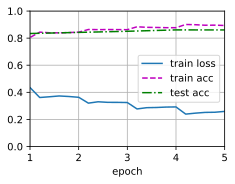

In [ ]:
lr, num_epochs = 0.01, 5
trainer = torch.optim.Adam(net.parameters(), lr=lr)
loss = nn.CrossEntropyLoss(reduction="none")
d2l.train_ch13(net, train_iter, test_iter, loss, trainer, num_epochs, devices)

### Saving the trained model

In [ ]:
torch.save(net.state_dict(), "/content/trained_3rd_1.h5")

### Defining a predicting function to use the model and predict the sentiment in texts

In [16]:
def predict_sentiment(net, vocab, sequence):
    """Predict the sentiment of a text sequence."""
    sequence = torch.tensor(vocab[sequence.split()], device=d2l.try_gpu())
    label = torch.argmax(net(sequence.reshape(1, -1)), dim=1)
    return 'positive' if label == 1 else 'negative'

## load trained model

In [21]:
model = BiRNN(len(vocab), embed_size, num_hiddens, num_layers).cuda()
model.load_state_dict(torch.load("/content/drive/My Drive/models/trained_3rd_0.861.h5"))
model.eval()

BiRNN(
  (embedding): Embedding(49346, 100)
  (encoder): LSTM(100, 100, num_layers=2, bidirectional=True)
  (decoder): Linear(in_features=400, out_features=2, bias=True)
)

In [22]:
predict_sentiment(model, vocab, 'i like iphone') #example

'positive'

### Running the model on five tweets and see the result

In [28]:
for_predicting=cleaned[10:15] # five tweets to analyze sentiments, for example only

In [30]:
# the printed text is as follows: tweet ---> sentiment (positive/negative)
for tweet in for_predicting:
  print(tweet,'---->',predict_sentiment(model, vocab, tweet))

cycle in the desert to fight climate change Iphone13 Breakingnews Tndiapolitics AndhraPolitics Aryan NewsFeed CovidImpact ChandaBabu New Delhi Nov 27 Subroto Chatterjee a London base sustainable product entrepreneur and environmental a ----> positive
comforter access -PRON- store through the profile gift wrappingpaper towel legging duvet pillow socks decor mats fashion Madrid London Canada iphone13 case yoga BTC ETH ADA USA Australia UnitedKingdom Dubai BlackFriday ----> positive
Comforters Duvets Blankets pillow and more gift wrappingpaper legging capri duvet pillow socks decor black sneaker fashion Madrid London Canada iphone13 case yoga BTC ETH ADA USA Australia UnitedKingdom Dubai BlackFriday ----> positive
Capri Leggings access -PRON- store through the profile snake legging capri duvet pillow socks decor black sneaker fashion Madrid London Canada iphone13 case yoga BTC ETH ADA USA Australia UnitedKingdom Dubai BlackFriday ----> positive
Tony Blair Institution Indias 15 top NGOs to

### Find the sentiment in all the tweets

In [135]:
# Finding sentiments
sentiment={}
for tweet in cleaned:
  sentiment[tweet]=predict_sentiment(model, vocab, tweet)

In [136]:
# Select the positive tweets
positive=[k for k,v in sentiment.items() if v == 'positive']
positive_count=len(positive)

In [137]:
# Select the negative tweets
negative=[k for k,v in sentiment.items() if v == 'negative']
negative_count=len(negative)

### Showing the results in figures

#### Piechart number of positive and negative tweets

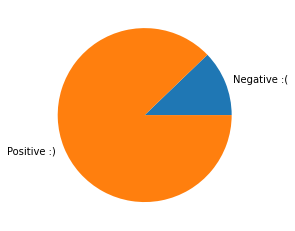

In [138]:
# Plotting the number of positive and negative tweets in term of pie chart 
y = np.array([negative_count, positive_count])
mylabels = ["Negative :(", "Positive :)"]

plt.pie(y, labels = mylabels)
plt.show() 

#### the most 100 frequent word in the negative tweets

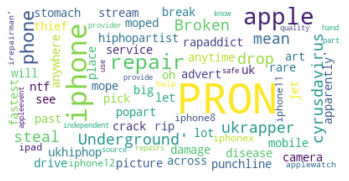

In [139]:
# plotting a word cloud of positive mentions of iPhone13 in the tweets
wordcloud = WordCloud(max_font_size=50, max_words=100, background_color="white").generate(str(negative))
plt.figure()
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

#### the most 100 frequent word in the positive tweets

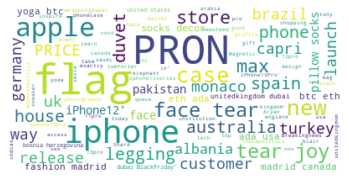

In [140]:
# plotting a word cloud of positive mentions of iPhone13 in the tweets
wordcloud = WordCloud(max_font_size=50, max_words=100, background_color="white").generate(str(positive))
plt.figure()
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()